In [1]:
import time
import random
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X_train  = np.loadtxt(r"C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\CatvsDog\cat_train_x.csv",delimiter=',')/255.0
y_train = np.loadtxt(r"C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\CatvsDog\cat_train_y.csv",delimiter=',').reshape(1, X_train.shape[1])

X_test = np.loadtxt(r"C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\CatvsDog\cat_test_x.csv",delimiter=',')/255.0
y_test = np.loadtxt(r"C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\CatvsDog\cat_test_y.csv",delimiter=',').reshape(1, X_test.shape[1])

In [3]:
print("Shape of X_train",X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_test",X_test.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train (12288, 209)
Shape of y_train (1, 209)
Shape of X_test (12288, 50)
Shape of y_test (1, 50)


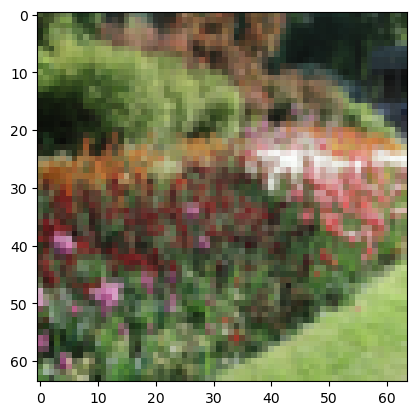

In [4]:
index = random.randrange(0,X_train.shape[1])
plt.imshow(X_train[:,index].reshape(64,64,3))
plt.show()

## Activation Functions

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x,0)

def softmax(x):
    expX = np.exp(x)
    return expX/(np.sum(expX,axis=0))

## Derivatives of Activation Function

In [6]:
def der_tanh(x):
    return (1-np.power(x,2))

def der_relu(x):
    return np.array(x>0, dtype='float')

## Initilaize parameters

In [7]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    
    for l in range(1,len(layer_dims)):
        parameters["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters["b"+str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [8]:
layer_dims = [X_train.shape[0],100,200,y_train.shape[0]]
params = initialize_parameters(layer_dims)

In [9]:
for i,j in params.items():
    print(i,params[i].shape)

W1 (100, 12288)
b1 (100, 1)
W2 (200, 100)
b2 (200, 1)
W3 (1, 200)
b3 (1, 1)


## Forward_Propagation

In [10]:
def forward_propagation(X,parameters,activation):
    
    forward_cache ={}
    L = len(parameters) // 2
    
    forward_cache['A0'] = X
    
    for l in range(1,L):
        forward_cache['Z'+str(l)] = parameters['W'+str(l)].dot(forward_cache['A'+str(l-1)]) + parameters['b'+str(l)]
        if activation == 'relu':
            forward_cache['A'+str(l)] = relu(forward_cache['Z'+str(l)])
        else:
            forward_cache['A'+str(l)] = tanh(forward_cache['Z'+str(l)])
        
    forward_cache['Z'+str(L)] = parameters['W'+str(L)].dot(forward_cache['A'+str(L-1)]) + parameters['b'+str(L)]
    
    if forward_cache['Z'+str(L)].shape[0] == 1:
        forward_cache['A'+str(L)] = sigmoid(forward_cache['Z'+str(L)])
    else:
        forward_cache['A'+str(L)] = softmax(forward_cache['Z'+str(L)])
    
    return forward_cache['A'+str(L)],forward_cache

In [11]:
aL, forward_cache = forward_propagation(X_train,parameters=params,activation='relu')

for l in range(len(params)//2+1):
    print("Shape of A"+str(l)+" :", forward_cache['A'+str(l)].shape)

Shape of A0 : (12288, 209)
Shape of A1 : (100, 209)
Shape of A2 : (200, 209)
Shape of A3 : (1, 209)


In [68]:
#aL is the last layer

In [13]:
forward_cache['A3'].shape

(1, 209)

# Cost Function

#### For binary classification:
$ Cost = - \frac{1}{m} \sum_{i=1}^{m} [ y*log(a_L) + (1-y)*log(1 - a_L) ] $

#### For multi-class classification:

$ Cost = - \frac{1}{m} \sum_{i=1}^{m} \sum_{i=k}^{n}[ y_k*log(a_k) ]$

# L2 Regularization

## Cost Function
Update the cost function with :

$Cost = Cost + \frac{\lambda}{2m} * \sum^{L}_{l=1}\sum_{i=1}\sum_{j=1} | W^{[l]}_{ij} |^2$


## Backward Propagation
For every i in layers of neural network, update $dW_i$ with :

$dW_i = dW_i + \frac{\lambda}{m}*W_i$


In [57]:
def compute_cost(AL,Y,parameters,lambd):
    
    params = len(parameters)//2
    
    L2_regularization_cost = 0
    for i in range(1,params+1):
        L2_regularization_cost+= np.sum(np.square(parameters['W'+str(i)]))
    
    m = Y.shape[1]
    
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) + (lambd/(2*m))*L2_regularization_cost
    else:
        cost = -(1/m) * np.sum( Y*np.log(AL)) + (lambd/(2*m))*L2_regularization_cost
        
    cost = np.squeeze(cost)
    
    return cost

## BackPropagation

In [47]:
def back_propagation(AL,Y,parameters,forward_cache,activation,lambd):
    
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    # for the last layer
    grads['dZ' + str(L)] = AL-Y
    grads['dW' + str(L)] = (1./m) * np.dot(grads['dZ' + str(L)],forward_cache['A'+str(L-1)].T) + (lambd*parameters['W'+str(L)])/m
    grads['db' + str(L)] = (1./m) * np.sum(grads['dZ' + str(L)], axis = 1,keepdims=True)
    
    for l in reversed(range(1,L)):
        if activation == 'relu':
            grads['dZ' + str(l)] = np.dot(parameters["W"+str(l+1)].T,grads['dZ' + str(l+1)]) * der_relu(forward_cache["A"+str(l)])
        else:
            grads['dZ' + str(l)] = np.dot(parameters["W"+str(l+1)].T,grads['dZ' + str(l+1)]) * der_tanh(forward_cache["A"+str(l)])
        grads['dW' + str(l)] = (1./m) * np.dot(grads['dZ' + str(l)],forward_cache['A'+str(l-1)].T)  + (lambd*parameters['W'+str(l)])/m
        grads['db' + str(l)] = (1./m) * np.sum(grads['dZ' + str(l)], axis = 1,keepdims=True)

    return grads


In [49]:
grads = back_propagation(aL,y_train,params,forward_cache,"relu",0.7)

for l in reversed(range(1,len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 209)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)
Shape of dW1 : (100, 12288)
Shape of dB1 : (100, 1) 



## Update Parameters

In [50]:
def update_parameters(parameters,grads,learning_rate):
    
    L = len(parameters)//2
    
    for l in range(1,L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+ str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+ str(l)]
        
    return parameters

In [51]:
def accuracy(X,y, parameters,activation='relu'):
    
    m = X.shape[1]
    
    y_pred, caches = forward_propagation(X,parameters,activation)
       
    if y.shape[0]==1:
        y_pred = np.array(y_pred>0.5,dtype='float')  
    else:
        y = np.argmax(y, 0) #Just because since it is multi-class classification the actual values are one hot encoded
        y_pred = np.argmax(y_pred, 0) #0 represents row wise
    
    return np.round(np.sum(y_pred == y)/m,2)

In [65]:
def model(x,y,layer_dims,learning_rate,activation = 'relu',num_iterations = 100,lambd):
    
    np.random.seed(1)
    cost_list = []
    
    parameters = initialize_parameters(layer_dims)
    
    for i in range(num_iterations):
        aL,forward_cache = forward_propagation(x,parameters,activation)
        
        cost = compute_cost(aL,y,parameters,lambd)
        
        gradients = back_propagation(aL,y,parameters,forward_cache,activation,lambd)
        
        parameters = update_parameters(parameters,gradients,learning_rate)
        
        cost_list.append(cost)
        
        if(i%(num_iterations/10)==0):
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), accuracy(X_train, y_train, parameters, activation), accuracy(X_test, y_test, parameters, activation)))
            
        if i % 10 == 0:
            print("==", end = '')
        
    return parameters,cost_list

In [66]:
layer_dims = [X_train.shape[0],20,7,5,y_train.shape[0]]
lr = 0.0075
iters = 2500
lambd = 0.7
parameters,costlist = model(X_train,y_train,layer_dims,learning_rate=lr,activation='relu',num_iterations=iters,lambd)


iter:0 	 cost: 0.83 	 train_acc:0.51 	 test_acc:0.42
iter:250 	 cost: 0.69 	 train_acc:0.77 	 test_acc:0.6
iter:500 	 cost: 0.59 	 train_acc:0.78 	 test_acc:0.5
iter:750 	 cost: 0.45 	 train_acc:0.93 	 test_acc:0.78
iter:1000 	 cost: 0.37 	 train_acc:0.91 	 test_acc:0.56
iter:1250 	 cost: 0.28 	 train_acc:0.97 	 test_acc:0.7
iter:1500 	 cost: 0.24 	 train_acc:0.98 	 test_acc:0.82
iter:1750 	 cost: 0.2 	 train_acc:0.99 	 test_acc:0.82
iter:2000 	 cost: 0.18 	 train_acc:0.99 	 test_acc:0.82
iter:2250 	 cost: 0.16 	 train_acc:0.99 	 test_acc:0.8

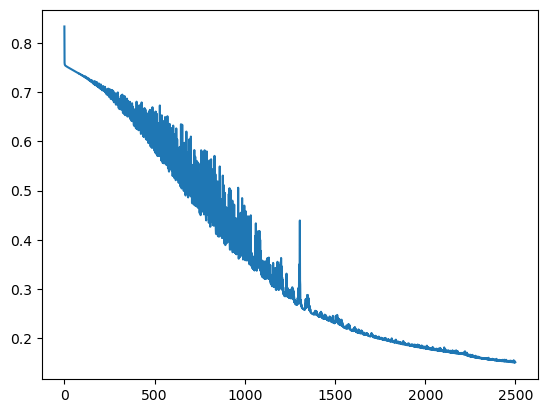

In [67]:
t = np.arange(0, iters)
plt.plot(t, costlist)
plt.show()